<html>
    <summary></summary>
         <div> <p></p> </div>
         <div style="font-size: 20px; width: 800px;">
              <h1>
               <left>Stochastic modeling of bacteria growth</left>
              </h1>
              <p><left>============================================================================</left> </p>
<pre>Course: ASU CBP Summer School 2025
Instructor: Dr. Douglas Shepherd
Contact Info: douglas.shepherd@asu.edu
Authors: Dr. Douglas Shepherd
</pre>
         </div>
    </p>

</html>

<details>
  <summary>Copyright info</summary>

```
Copyright 2025 Douglas Shepherd

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```
<details>



In [1]:
!pip install pymc arviz numcodecs imagecodecs tiffile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 33.1 MB/s eta 0:00:00


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/QI2lab/2025-CBP-SummerSchool/blob/main/Module4-BacteriaGrowth/M4C_Stochastic_Growth_Rate.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/QI2lab/2025-CBP-SummerSchool/blob/main/Module4-BacteriaGrowth/M4C_Stochastic_Growth_Rate.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Learning Objectives
In this lesson, we are going to use an advancedd method, called Markov Chain Monte Carlo (MCMC) to analyze and fit experimental data of bacteria dividing to determine their growth rate. To fully understand this material, you will need to go over the optional material in Module 5.

After completing this lesson, you should be able to:
* Fit the distribution of cell division times using an ODE model, MCMC sampling, and the experimental data.

### Import packages

In [2]:
import pymc as pm
import numpy as np
import arviz as az
import tifffile
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import xarray as xr

### Setup HMC for exponential growth

We are going to use [PyMC](https://www.pymc.io/welcome.html), a probabilistic programming library, to fit the data in this example.

At a high-level, the idea is to try many different random parameter combinations and see how well the model fits for each combination. By adding up all of the times the solver found a given growth rate value fit the model "well", we can then make a distribution of the most likely growth rates given the model and data.

In [21]:
def exponential_solution(times: np.ndarray, k1: float, N0: float) -> np.ndarray:
  """Analytic solution N(t) = N0 * exp(k1 * t)."""
  return N0 * np.exp(k1 * times)

def build_model_counts_neg_bin(times: np.ndarray, counts: np.ndarray) -> pm.Model:
  """PyMC model: counts ~ NegBin(mu=N0*exp(k1*t), alpha).

  Parameters
  ----------
  times
      1D array of timepoints (shape (T,)).
  counts
      1D or 2D array of integer counts. If 2D (R, T), each row is a replicate.

  Returns
  -------
  model
      A compiled PyMC model ready for sampling.
  """
  times = np.asarray(times, dtype=float)
  counts = np.asarray(counts)

  # If replicates are provided as (R, T), broadcast mu over the replicate axis
  if counts.ndim == 2:
    R, T = counts.shape
    assert T == times.size
  else:
    T = counts.size
    assert T == times.size
    counts = counts[None, :]       # (1, T) for uniform handling
    R = 1

  with pm.Model() as model:
    # Weakly-informative priors (tune these if you have prior knowledge)
    k1 = pm.LogNormal("k1", mu=0.05, sigma=.5)        # k1 > 0
    N0 = pm.LogNormal("N0", mu=np.log(max(counts.mean(), 1.0)), sigma=2.0)

    # Overdispersion (alpha -> 0 becomes Poisson-like)
    alpha = pm.HalfNormal("alpha", sigma=2.0)

    mu_t = exponential_solution(times, k1, N0)        # shape (T,)
    mu = pm.Deterministic("mu", mu_t)                 # keep for diagnostics

    # Likelihood: broadcast across replicates
    pm.NegativeBinomial(
        "obs", mu=mu[None, :], alpha=alpha, observed=counts
    )

  return model

### Load and read in experimental data

In [4]:
# Download data
!pip install -q gdown
import gdown

# download the .zip containing the image data
file_id = "1nxY9-jEGmrH8elRdiMENFhBb64mMYl8q"
out = "/content/cbpSS2025.zip"
gdown.download(id = file_id, output=out,quiet=False)

# unzip data
!unzip -q /content/cbpSS2025.zip -d /content/cbpSS2025/

file_id = "1nW_-ouf_6THFhuoXNEL5GkcB3twmYQNS"
out = "/content/cbpSS2025/tracking_result.txt"

# Using the ID avoids any Drive viewer HTML
gdown.download(id=file_id, output=out, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1nxY9-jEGmrH8elRdiMENFhBb64mMYl8q
From (redirected): https://drive.google.com/uc?id=1nxY9-jEGmrH8elRdiMENFhBb64mMYl8q&confirm=t&uuid=c0117fdb-37e9-4ce8-ac63-0bae06e8c04e
To: /content/cbpSS2025.zip
100%|██████████| 32.0M/32.0M [00:00<00:00, 82.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1nW_-ouf_6THFhuoXNEL5GkcB3twmYQNS
To: /content/cbpSS2025/tracking_result.txt
100%|██████████| 3.96k/3.96k [00:00<00:00, 7.50MB/s]


'/content/cbpSS2025/tracking_result.txt'

In [5]:
# load segmented phase-contrast image data
mask_files = sorted(Path("/content/cbpSS2025/masks/").glob("*.tif*"))
mask_data = []
for mask_file in mask_files:
  mask_data.append(tifffile.imread(mask_file))
mask_data = np.asarray(mask_data,dtype=np.uint16)[0:20,:]

In [6]:
# load segmented and tracked phase-contrast image data
tracked_files = sorted(Path("/content/cbpSS2025/result/").glob("*.tif*"))
tracked_data = []
for tracked_file in tracked_files:
  tracked_data.append(tifffile.imread(tracked_file))
tracked_data = np.asarray(tracked_data,dtype=np.uint16)[0:20,:,:]

### Process segmented data to get number of bacteria per timepoint

In [7]:
bacteria_counts = np.max(mask_data,axis=(1,2))
times = np.linspace(0,mask_data.shape[0],mask_data.shape[0]) * 5

### Process tracked data to get distribution of division times

In [8]:
def division_time_histogram(
    filename: str | Path,
    timestep_min: float,
    bins: int | str = "auto",
) -> tuple[np.ndarray, np.ndarray]:
  """Compute a histogram of cell division times from a TrackAstra result file.

  The input file must have 4 whitespace-separated integer columns per line:
  L B E P
    - L: track label (positive int)
    - B: birth frame index (0-based)
    - E: end frame index (0-based)
    - P: parent label (0 if no parent)

  A division event is defined as any parent label with >= 2 daughters.
  The division frame is the mode (most frequent) of the daughters' birth
  frames for that parent; ties resolve to the smallest such frame. Division
  time (minutes) = (division_frame - parent_birth_frame) * timestep_min.

  Parameters
  ----------
  filename
      Path to the TrackAstra track file.
  timestep_min
      Minutes per frame (e.g., 5.0 for 5-minute intervals).
  bins
      Binning specification passed to ``np.histogram`` (default "auto").

  Returns
  -------
  counts : np.ndarray, shape (n_bins,)
      Histogram counts per bin.
  bin_centers : np.ndarray, shape (n_bins,)
      Bin center locations (minutes), suitable for plotting.

  Notes
  -----
  - Lines with fewer than two daughters for a parent are ignored.
  - Events with non-positive elapsed frames are ignored.

  Examples
  --------
  >>> counts, centers = division_time_histogram("res_track.txt", 5.0)
  >>> import matplotlib.pyplot as plt
  >>> plt.plot(centers, counts, marker="o")
  >>> plt.xlabel("Division time (min)")
  >>> plt.ylabel("Count")
  >>> plt.show()
  """
  arr = np.loadtxt(filename, dtype=np.int64)
  if arr.ndim != 2 or arr.shape[1] < 4:
      raise ValueError("Track file must have 4 columns: L B E P.")

  labels = arr[:, 0]
  births = arr[:, 1]
  parents = arr[:, 3]

  # Map: label -> birth frame
  label_to_birth: dict[int, int] = {}
  for lbl, b in zip(labels, births):
      # If duplicated labels appear, keep the first B seen.
      label_to_birth.setdefault(int(lbl), int(b))

  # Map: parent_label -> list of row indices of daughters
  daughters_by_parent: dict[int, list[int]] = {}
  for idx, p in enumerate(parents):
      if p != 0:
          daughters_by_parent.setdefault(int(p), []).append(idx)

  division_times_min: list[float] = []

  for parent_lbl, idxs in daughters_by_parent.items():
      if len(idxs) < 2:
          continue
      # Parent must exist in table (to have birth time)
      parent_birth = label_to_birth.get(parent_lbl)
      if parent_birth is None:
          continue

      daughter_birth_frames = births[idxs].astype(int)
      # Mode of daughters' birth frames (tie -> smallest)
      vals, cnts = np.unique(daughter_birth_frames, return_counts=True)
      division_frame = int(vals[np.argmax(cnts)])
      frames_elapsed = int(division_frame - parent_birth)
      if frames_elapsed <= 0:
          continue

      division_times_min.append(frames_elapsed * float(timestep_min))

  times = np.asarray(division_times_min, dtype=float)
  if times.size == 0:
      # No valid events
      return np.array([], dtype=float), np.array([], dtype=float)

  counts, bin_edges = np.histogram(times, bins=bins)
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
  return counts.astype(float, copy=False), bin_centers

division_times, bin_center = division_time_histogram(
  filename = Path("/content/cbpSS2025/tracking_result.txt"),
  timestep_min = 5
)

### Run the MCMC sampling using PyMC

In [22]:
with build_model_counts_neg_bin(times, bacteria_counts) as m:
    idata = pm.sample(10000, tune=2000, chains=4, target_accept=0.9)
    ppc = pm.sample_posterior_predictive(idata)
    dt = np.log(2.0) / idata.posterior["k1"]
    idata.posterior = idata.posterior.assign(doubling_time=dt)

Output()

Output()

### Plot distribution of sampled division times versus actual division times

In [23]:
def _approx_edges_from_centers(centers: np.ndarray) -> np.ndarray:
    """Compute bin edges from bin centers (works for uniform or varying widths)."""
    centers = np.asarray(centers, dtype=float)
    if centers.size == 0:
        raise ValueError("bin_centers must be non-empty.")
    if centers.size == 1:
        step = 1.0
        return np.array([centers[0] - step/2, centers[0] + step/2])
    edges = np.empty(centers.size + 1, dtype=float)
    edges[1:-1] = 0.5 * (centers[:-1] + centers[1:])
    edges[0] = centers[0] - (centers[1] - centers[0]) / 2.0
    edges[-1] = centers[-1] + (centers[-1] - centers[-2]) / 2.0
    return edges

def _get_dt_samples(idata: az.InferenceData, prefer_existing: bool = True) -> np.ndarray:
    """Extract doubling-time samples from idata (uses 'doubling_time' if present; else ln2/k1)."""
    post: xr.Dataset = idata.posterior  # (chain, draw, ...)
    if prefer_existing and "doubling_time" in post:
        dt = post["doubling_time"].values
    else:
        if "k1" not in post:
            raise KeyError("Neither 'doubling_time' nor 'k1' found in idata.posterior.")
        k1 = post["k1"].values
        dt = np.log(2.0) / k1
    dt = np.asarray(dt, dtype=float).reshape(-1)  # flatten (chains * draws,)
    dt = dt[np.isfinite(dt) & (dt > 0)]
    if dt.size == 0:
        raise ValueError("No valid (positive, finite) doubling-time samples found.")
    return dt

def _hist_median(counts: np.ndarray, edges: np.ndarray) -> float:
    """Median of a 1D histogram using linear interpolation inside the median bin."""
    counts = np.asarray(counts, dtype=float)
    edges = np.asarray(edges, dtype=float)
    total = counts.sum()
    if total <= 0:
        return np.nan
    csum = np.cumsum(counts)
    half = 0.5 * total
    # First bin where cumulative >= half
    idx = int(np.searchsorted(csum, half, side="left"))
    idx = np.clip(idx, 0, counts.size - 1)
    c_before = 0.0 if idx == 0 else csum[idx - 1]
    in_bin = counts[idx]
    lo, hi = edges[idx], edges[idx + 1]
    if in_bin <= 0 or not np.isfinite(in_bin):
        # Fallback: center of the bin if it’s empty or weird
        return 0.5 * (lo + hi)
    frac = (half - c_before) / in_bin
    frac = np.clip(frac, 0.0, 1.0)
    return lo + frac * (hi - lo)

def plot_true_vs_posterior_doubling_time(
    counts: np.ndarray,
    bin_centers: np.ndarray,
    idata: az.InferenceData,
    *,
    show_kde: bool = True,
    show_ppc: bool = True,
    hdi_prob: float = 0.95,
) -> None:
    """Overlay the empirical division-time histogram with posterior for doubling time.

    - Bars: empirical histogram as a *density* (area=1)
    - Line: KDE of posterior doubling-time samples (optional, show_kde=True)
    - Markers: posterior-predictive expected *counts per bin* (optional, show_ppc=True)
    - Vertical dotted line: empirical median division time
    """
    counts = np.asarray(counts, dtype=float)
    centers = np.asarray(bin_centers, dtype=float)
    assert counts.shape == centers.shape, "counts and bin_centers must align"

    # Reconstruct edges and widths for density conversion
    edges = _approx_edges_from_centers(centers)
    widths = np.diff(edges)
    total = counts.sum()
    density = counts / (total * widths) if total > 0 else np.zeros_like(counts)

    # Empirical median (minutes) from the histogram
    emp_median = _hist_median(counts, edges)

    # Posterior samples of doubling time
    dt_samples = _get_dt_samples(idata)
    q_lo, q_hi = np.quantile(dt_samples, [(1 - hdi_prob) / 2, 1 - (1 - hdi_prob) / 2])
    dt_med = np.median(dt_samples)

    fig, ax = plt.subplots(figsize=(7, 4))

    # 1) Empirical histogram as density bars
    ax.bar(centers, density, width=widths, align="center", alpha=0.4, label="Empirical density")

    # 1b) Empirical median line
    if np.isfinite(emp_median):
        ax.axvline(emp_median, linestyle=":", linewidth=1.5,
                   label=f"Empirical median = {emp_median:.2f}")

    # 2) KDE of posterior doubling time (density)
    if show_kde:
        kde = gaussian_kde(dt_samples)
        # x-grid spanning both data & posterior
        x_min = min(edges[0], np.quantile(dt_samples, 0.001))
        x_max = max(edges[-1], np.quantile(dt_samples, 0.999))
        x = np.linspace(x_min, x_max, 512)
        y = kde(x)
        ax.plot(x, y, label="Posterior KDE of doubling time")
        # Shade HDI and mark posterior median
        ax.axvspan(q_lo, q_hi, alpha=0.1, label=f"{int(hdi_prob*100)}% HDI (doubling time)")
        ax.axvline(dt_med, linestyle="--", linewidth=1.2, label=f"Posterior median = {dt_med:.2f}")

    # 3) Posterior-predictive counts-in-bins from posterior dt samples
    if show_ppc:
        # Probability that dt falls in each bin ≈ fraction of samples in that bin
        bin_idx = np.digitize(dt_samples, edges) - 1  # 0..B-1
        bin_idx = bin_idx[(bin_idx >= 0) & (bin_idx < counts.size)]
        freq = np.bincount(bin_idx, minlength=counts.size).astype(float)
        prob_in_bin = freq / freq.sum() if freq.sum() > 0 else np.zeros_like(freq)
        expected_counts = total * prob_in_bin
        # Plot as markers connected at bin centers (convert to density to match bars)
        ax.plot(centers, expected_counts / (total * widths), marker="o",
                linestyle="-", label="Posterior-predictive density (binned)")

    ax.set_xlabel("Division time / Doubling time (minutes)")
    ax.set_ylabel("Density")
    ax.set_title("Empirical distribution vs posterior for doubling time")
    ax.legend()
    plt.tight_layout()
    plt.show()

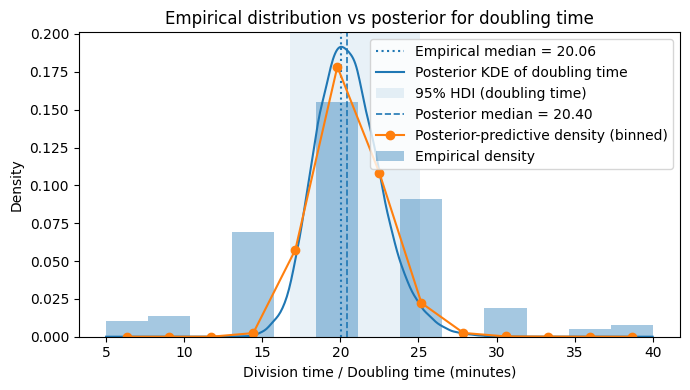

In [24]:
plot_true_vs_posterior_doubling_time(
    counts=division_times,
    bin_centers=bin_center,
    idata=idata,
    show_kde=True,
    show_ppc=True,
    hdi_prob=0.95,
)

This worked out pretty well!